In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
# import cv2
import random

In [3]:
resize= (150,150)
train_path, test_path = "./seg_train/seg_train/", "./seg_test/seg_test/"

In [4]:
root = pathlib.Path(train_path)
classes = sorted([j.stem for j in root.iterdir() if not j.name.startswith(".")]) # To escape .DS_Store file

In [5]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet, self).__init__()
    # Input shape: 
    # batch_size, channels, image_size_height, image_size_width
    # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    #(256, 3, 150, 150)
    
    # Output shape: 
    # Output height = (Input height + padding height top + padding height bottom - kernel height) / (stride height) + 1
    # Output width = (Output width + padding width right + padding width left - kernel width) / (stride width) + 1
    #               (150+1+1-3)/1+1 = 150
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        # (256, 12, 150, 150)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        # (256, 12, 150, 150)
        self.relu1 = nn.ReLU()
        # (256, 12, 150, 150)
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Reduce the image size by kernel_size
        # (256, 12, 75, 75)
        
        self.conv2= nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        # (256, 20, 75, 75)
        self.relu2 = nn.ReLU()
        # (256, 20, 75, 75)

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        # (256, 32, 75, 75)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        # (256, 32, 75, 75)
        self.relu3 = nn.ReLU()
        # (256, 32, 75, 75)
        
        self.fc = nn.Linear(in_features=32*resize[0]//2*resize[1]//2, out_features=num_classes)
        
    def forward(self, inp):
        output = self.conv1(inp)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        output = output.view(-1, 32 * resize[0]//2 * resize[1]//2)
        output = self.fc(output)
        return output

In [6]:
checkpoint = torch.load("best_checkpoint.model")
model = ConvNet(len(classes))
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [7]:
transformer = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])])

In [8]:
def prediction(img_path, transformer):
    img = Image.open(img_path)
    image_tensor = transformer(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inp = Variable(image_tensor)
    output = model(inp)
    index = output.data.numpy().argmax()
    pred = classes[index]
    return pred

In [9]:
pred_path = "./seg_pred/seg_pred/"
img_path = glob.glob(pred_path+"/*.jpg")
pred_dict = {}
for idx, i in enumerate(img_path):
    if idx % 500==0: print(f"image {idx}")
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

image 0


/Users/smol/.pyenv/versions/3.9.1/envs/ML/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/smol/repo/pytorch/c10/core/TensorImpl.h:1260.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


image 500
image 1000
image 1500
image 2000
image 2500
image 3000
image 3500
image 4000
image 4500
image 5000
image 5500
image 6000
image 6500
image 7000


('17377.jpg', 'buildings')


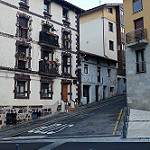

In [26]:
f = random.choice(list(pred_dict.items()))
print(f)
Image.open(pred_path+f[0]) 